# **HW7 พัฒนา discord bot มาดูแลการสอบ**

การสอบกลางภาคกำลังใกล้เข้ามาเรื่อย ๆ การบ้านนี้เราจะมาเขียน bot ที่ใช้ดูแลการสอบที่เราสมมุติขึ้นมากัน 





## **สถานการณ์การสอบสมมุติ**

ในการสถานการณ์สมมุตินี้ นิสิตเข้าสอบผ่านกระบวนการคร่าว ๆ ดังนี้

*   เริ่มต้นด้วยการ sign in ผ่านคำสั่ง `.sign_in <เลขประจำตัวนิสิต>` แล้ว bot จะกล่าวทักทายพร้อมทั้งแจ้งกฎกติกาการสอบ หลังจากนั้น bot ก็จะส่งคำถามข้อแรกให้
*   นิสิตสามารถส่งคำตอบของคำถามปัจจุบันได้ด้วยคำสั่ง `.answer <คำตอบ>` โดย bot จะตอบรับโดยส่งคำถามข้อถัดไปมาให้

โดยคำถามที่ bot ส่งมาให้นั้นจะเป็นการสุ่มคำถามจากชุดคำถามที่ได้เตรียมไว้ 

## **วิธีการเก็บข้อมูลของ bot**

**!! ตรงนี้สำคัญ ถ้าพบเห็น uid, sid, questions, answers, qidx ใน section ถัด ๆ ไป จะหมายถึงข้อมูลนิสิตที่พูดถึงใน section นี้ !!**

ระบบจะเก็บข้อมูลการสอบของนิสิตทุกคนไว้ใน list `exam_info` โดยสมาชิกแต่ละตัวใน list นี้จะเป็นข้อมูลการสอบของนิสิตแต่ละคน ซึ่งข้อมูลการสอบของนิสิตแต่ละคนก็จะเก็บอยุ่ในรูปแบบ list ที่มีสมาชิก 5 ตัวเรียงตามลำดับดังนี้

*   `uid` - เก็บ discord user id ของนิสิต
*   `sid` - เก็บเลขประจำตัวนิสิต
*   `questions` - เป็น list เก็บคำถามที่ bot ได้สุ่มขึ้นมา
*   `answers` - เป็น list เก็บคำตอบที่นิสิตตอบ โดย `answers[i]` จะเป็นคำตอบของ `questions[i]`
*   `qidx` - เป็น index ชี้ไปยังคำถามที่นิสิตกำลังจะทำหรือกำลังทำอยู่ (สามารถมองได้อีกนัยหนึ่งว่าเป็นจำนวนคำถามที่นิสิตได้ตอบไปเรียบร้อยแล้ว

ยกตัวอย่างเช่น

```
exam_info = [[123456, "6430000021", ['Q05', 'Q01', 'Q02'], ['10', '12', '50'], 3], 
             [234567, "6430000121", ['Q03', 'Q05'], ['20'], 1]]
```

ในตัวอย่างนี้มีนิสิตกำลังทำสอบอยู่สองคน

*   คนแรกมีเลขประจำตัวนิสิต 6430000021 มีเลข discord id คือ 123456 ได้ทำข้อสอบไปแล้ว 3 ข้อคือ Q05 Q01 และ Q02 โดยได้ตอบคำถามทั้งสามข้อว่า 10, 12 และ 50 ตามลำดับ ถัดจากนี้ bot จะสุ่มคำถามข้อที่ 4 มาให้
*   คนที่สองมีเลขประจำตัวนิสิต 6430000121 มีเลข discord id คือ 234567 กำลังทำข้อที่ 2 อยู่








## **flow การทำงาน**

ตัวอย่างใน section นี้จะแสดงการเปลี่ยนแปลงของข้อมูลนิสิตเลขประจำตัว S_01 ใน exam_info ตั้งแต่เริ่มทำสอบจนกระทั่งสอบเสร็จ (รายละเอียดว่า function ต่างๆทำงานอย่างไรจะอยู่ในหัวข้อถัดไป)

```
#คำสั่ง
exam_info = []
all_questions = ['Q01', 'Q02', 'Q03', 'Q04', 'Q05']
```
<pre>
<table>
<tr><td>คำอธิบาย</td><td>คำสั่ง Python</td><td>ข้อมูลใน exam_info</td></tr>
<tr><td colspan=3>user 111 เข้าสู่ระบบ</td><tr>
<tr>
<td>
&nbsp;&nbsp;bot เรียก sign_in เพิ่มข้อมูล<br>
&nbsp;&nbsp;bot เรียก get_question <br>
&nbsp;&nbsp;สุ่มได้คำถาม Q02 แล้วเพิ่มให้
</td>
<td>
sign_in(111, 'S_01', exam_info)<br>
q = get_question(111, exam_info, all_questions)<br>&nbsp;
</td>
<td>
[[111, 'S_01', [], [], 0]]<br>
[[111, 'S_01', ['Q02'], [], 0]]<br>
get_question คืน 'Q02' ให้ q
</td>
</tr>
<tr><td colspan=3>user 111 ตอบคำถาม Q02 (qidx 0) ว่า '77'</td></tr>
<tr>
<td>
&nbsp;&nbsp;bot เรียก submit_answer<br>
&nbsp;&nbsp;สังเกตว่า qidx เพิ่มเป็น 1<br>
&nbsp;&nbsp;bot เรียก get_question<br>
&nbsp;&nbsp;สุ่มได้คำถาม Q04 แล้วเพิ่มให้
</td>
<td>
submit_answer(111, '77', exam_info)<br>&nbsp;<br>
q = get_question(111, exam_info, all_questions)<br>&nbsp;
</td>
<td>[[111, 'S_01', ['Q02'], ['77'], 1]]<br>&nbsp;<br>
[[111, 'S_01', ['Q02', Q04'], ['77'], 1]]<br>
get_question คืน 'Q04' ให้ q
</td>
</tr>
<tr>

<tr><td colspan=3>user 111 ตอบคำถาม Q04 (qidx 1) ว่า '20'</td></tr>
<tr>
<td>
&nbsp;&nbsp;bot เรียก submit_answer<br>
&nbsp;&nbsp;สังเกตว่า qidx เพิ่มเป็น 2<br>
&nbsp;&nbsp;bot เรียก get_question<br>
&nbsp;&nbsp;สุ่มได้คำถาม Q01 แล้วเพิ่มให้
</td>
<td>
submit_answer(111, '20', exam_info)<br>&nbsp;<br>
q = get_question(111, exam_info, all_questions)<br>&nbsp;
</td>
<td>[[111, 'S_01', ['Q02','Q04'], ['77','20'], 2]]<br>&nbsp;<br>
[[111, 'S_01', ['Q02','Q04','Q01'], ['77','20'], 2]]<br>
get_question คืน 'Q01' ให้ q
</td>
</tr>

<tr><td colspan=3>user 111 ตอบคำถาม Q01 (qidx 2) ว่า '50'</td></tr>
<tr>
<td>
&nbsp;&nbsp;bot เรียก submit_answer<br>
&nbsp;&nbsp;สังเกตว่า qidx เพิ่มเป็น 3<br>
&nbsp;&nbsp;bot เรียก get_question<br>
&nbsp;&nbsp;สุ่มได้คำถาม Q03 แล้วเพิ่มให้
</td>
<td>
submit_answer(111, '50', exam_info)<br>&nbsp;<br>
q = get_question(111, exam_info, all_questions)<br>&nbsp;
</td>
<td>[[111, 'S_01', ['Q02','Q04','Q01'], ['12','20','50'], 3]]<br>&nbsp;<br>
[[111, 'S_01', ['Q02','Q04','Q01','Q03'], ['12','20','50'], 3]]<br>
get_question คืน 'Q03' ให้ q
</td>
</tr>

<tr><td colspan=3>user 111 ตอบคำถาม Q03 (qidx 3) ว่า '007'</td></tr>
<tr>
<td>
&nbsp;&nbsp;bot เรียก submit_answer<br>
&nbsp;&nbsp;สังเกตว่า qidx เพิ่มเป็น 4<br>
&nbsp;&nbsp;bot เรียก get_question<br>
&nbsp;&nbsp;สุ่มได้คำถาม Q05 แล้วเพิ่มให้
</td>
<td>
submit_answer(111, '007', exam_info)<br>&nbsp;<br>
q = get_question(111, exam_info, all_questions)<br>&nbsp;
</td>
<td>[[11111, 'S_01', ['Q02', 'Q04', 'Q01', 'Q03'], ['77', '20', '50', '007'], 4]]<br>&nbsp;<br>
[[111, 'S_01', ['Q02', 'Q04', 'Q01', 'Q03', 'Q05'], ['77', '20', '50', '007'], 4]]<br>
get_question คืน 'Q05' ให้ q
</td>
</tr>

<tr><td colspan=3>user 111 ตอบคำถาม Q05 (qidx 4) ว่า '224'</td></tr>
<tr>
<td>
&nbsp;&nbsp;bot เรียก submit_answer<br>
&nbsp;&nbsp;สังเกตว่า qidx เพิ่มเป็น 5<br>
&nbsp;&nbsp;bot เรียก get_question<br>
&nbsp;&nbsp;เนื่องจากคำถามหมดแล้ว bot จึงคืน end มาให้<br>
&nbsp;&nbsp;สังเกตว่า end ไม่ได้ถูกเพิ่มเข้าไปใน questions
</td>
<td>
submit_answer(111, '224', exam_info)<br>&nbsp;<br>
q = get_question(111, exam_info, all_questions)<br>&nbsp;
</td>
<td>[[11111, 'S_01', ['Q02', 'Q04', 'Q01', 'Q03', 'Q05'], ['77', '20', '50', '007', '224'], 5]]<br>&nbsp;<br>
[[111, 'S_01',  ['Q02', 'Q04', 'Q01', 'Q03', 'Q05'], ['77', '20', '50', '007', '224'], 5]]<br>
get_question คืน 'end' ให้ q
</td>
</tr>

</table>
</pre>


# **งานที่จะต้องทำในการบ้านนี้**

ในการบ้านนี้นิสิตจะเขียน functions เพื่อให้สถานการณ์การสอบสมมุติสามารถทำงานได้

## **งานที่ 1 เขียน function `sign_in`**

```
def sign_in(uid, sid, exam_info):
```
function นี้จะตรวจสอบว่า uid หรือ sid มีอยู่ใน exam_info แล้วหรือไม่ ถ้ามีอยู่แล้วก็ไม่ต้องทำอะไร แต่ถ้ายังไม่มีก็เพิ่มสมาชิก `[uid, sid, [], [], 0]` เข้าไปใน exam_info

ตัวอย่าง 1

```
#คำสั่ง
exam_info = [[123456, "6430000021", ['Q05', 'Q01', 'Q02'], ['10', '12', '50'], 3],
             [234567, "6430000121", ['Q03', 'Q05'], ['20'], 1]]
sign_in(11111, "6430000021", exam_info)
for info in exam_info:
    print(info)
```

`exam_info` ไม่มีการเปลี่ยนแปลง เนื่องจากมี `sid` 6430000021 แล้ว จะแสดง 

```
#ผลลัพธ์ทางจอภาพ
[123456, '6430000021', ['Q05', 'Q01', 'Q02'], ['10', '12', '50'], 3]
[234567, '6430000121', ['Q03', 'Q05'], ['20'], 1]
```

ตัวอย่าง 2

```
#คำสั่ง
exam_info = [[123456, "6430000021", ['Q05', 'Q01', 'Q02'], ['10', '12', '50'], 3],
             [234567, "6430000121", ['Q03', 'Q05'], ['20'], 1]]
sign_in(123456, "6430000221", exam_info)
for info in exam_info:
    print(info)
```

`exam_info` ไม่มีการเปลี่ยนแปลง เนื่องจากมี `uid` 123456 แล้ว จะแสดง 

```
#ผลลัพธ์ทางจอภาพ
[123456, '6430000021', ['Q05', 'Q01', 'Q02'], ['10', '12', '50'], 3]
[234567, '6430000121', ['Q03', 'Q05'], ['20'], 1]
```

ตัวอย่าง 3

```
#คำสั่ง
exam_info = [[123456, "6430000021", ['Q05', 'Q01', 'Q02'], ['10', '12', '50'], 3],
             [234567, "6430000121", ['Q03', 'Q05'], ['20'], 1]]
sign_in(11111, "6430000221", exam_info)
for info in exam_info:
    print(info)
```

จะแสดง

```
#ผลลัพธ์ทางจอภาพ
[123456, '6430000021', ['Q05', 'Q01', 'Q02'], ['10', '12', '50'], 3]
[234567, '6430000121', ['Q03', 'Q05'], ['20'], 1]
[11111, '6430000221', [], [], 0]
```

ตัวอย่าง 4

```
#คำสั่ง
exam_info = []
sign_in(11111, "6430000221", exam_info)
print(exam_info)
```

จะแสดง

```
#ผลลัพธ์ทางจอภาพ
[[11111, '6430000221', [], [], 0]]
```




## **งานที่ 2 เขียน function `get_welcome_and_rules_msg`**

```
def get_welcome_and_rules_msg():
```

function นี้จะคืนผลเป็นข้อความต้อนรับและกฎกติกาในการสอบ โดยให้นิสิตสมมุติว่าถ้าตัวเองเป็นกรรมการคุมสอบ จะมีการกล่าวต้อนรับอย่างไร และมีกฎกติกาอะไรต้องแจ้งบ้าง

**สำคัญมาก** - ถ้าข้อความที่แสดงมี `None` ติดมาด้วยแปลว่าไม่ถูกต้องนะครับ

ตัวอย่าง

```
#คำสั่ง
print(get_welcome_and_rules_msg())
```

อาจจะแสดง

```
#ผลลัพธ์ทางจอภาพ
ยินดีต้อนรับสู่การสอบกลางภาคครับ

อยากแนะนำว่า อย่าเอาเปรียบเพื่อนเลยนะครับ ความทรงจำช่วงวัยรุ่นจะอยู่กับเราไปอีกนาน

ขอให้ทำข้อสอบได้ทุกคนครับ
```




## **งานที่ 3 เขียน function `get_student_info`**

```
def get_student_info(uid, exam_info):
```

function นี้จะคืนผลเป็นข้อมูลการสอบของนิสิตที่มี uid ตรงกับ uid ที่ function รับเข้ามา (รับประกันว่ามี uid ใน exam_info แน่นอน)

ตัวอย่าง 1

```
#คำสั่ง
exam_info = [[123456, "6430000021", ['Q05', 'Q01', 'Q02'], ['10', '12', '50'], 3],
             [234567, "6430000121", ['Q03', 'Q05'], ['20'], 1]]
info = get_student_info(123456, exam_info)
print(info)
```

จะแสดง

```
#ผลลัพธ์ทางจอภาพ
[123456, '6430000021', ['Q05', 'Q01', 'Q02'], ['10', '12', '50'], 3]
```

ตัวอย่าง 2

```
#คำสั่ง
exam_info = [[123456, "6430000021", ['Q05', 'Q01', 'Q02'], ['10', '12', '50'], 3],
             [234567, "6430000121", ['Q03', 'Q05'], ['20'], 1]]
info = get_student_info(45678, exam_info)
print(info)
```

จะแสดง

```
#ผลลัพธ์ทางจอภาพ
None
```






## **งานที่ 4 เขียน function `get_question`**

```
def get_question(uid, exam_info, all_questions):
```

function นี้จะคืนผลเป็นคำถามจาก `questions` ที่ถูกชี้ด้วย `qidx` ถ้า ณ ตำแหน่งนั้นยังไม่มีคำถาม function นี้จะต้องไปสุ่มเลือกคำถามมาจาก `all_questions` ซึ่งจะต้องเป็นคำถามที่นิสิตยังไม่ได้ตอบ

นอกจากจะคืนผลแล้ว function นี้จะต้องเพิ่มคำถามที่ได้ ต่อท้าย `questions` ด้วย 

แต่หากว่าคำถามหมดแล้วก็จะคืนคำว่า end มาให้โดยไม่เปลี่ยนแปลงใดๆกับ `questions`

**Tips:** แนะนำให้ใช้ประโยชน์จาก `get_student_info` ในการดึงข้อมูลของนิสิตที่มี `uid` ที่ต้องการ

ตัวอย่าง 1

```
#คำสั่ง
random.seed(1111) #การมีบรรทัดนี้มันจะทำให้ผล random ออกมาเหมือนเดิมทุกครั้ง(ไว้ใช้เปรียบเทียบคำตอบ) 
exam_info = [[123456, "6430000021", ['Q05', 'Q01', 'Q02'], ['10', '12', '50'], 3],
             [234567, "6430000121", ['Q03', 'Q05'], ['20'], 1]]
all_questions = ['Q01', 'Q02', 'Q03', 'Q04', 'Q05']
question = get_question(123456, exam_info, all_questions)
print(question)
info = get_student_info(123456, exam_info)
print(info)
```

`123456` ได้ตอบทั้งสามคำถามไปแล้ว ต้องสุ่มคำถามใหม่ (ได้ `Q03`) จะแสดง

```
#ผลลัพธ์ทางจอภาพ
Q03
[123456, '6430000021', ['Q05', 'Q01', 'Q02', 'Q03'], ['10', '12', '50'], 3]
```

ตัวอย่าง 2

```
#คำสั่ง
random.seed(1111) #การมีบรรทัดนี้มันจะทำให้ผล random ออกมาเหมือนเดิมทุกครั้ง(ไว้ใช้เปรียบเทียบคำตอบ) 
exam_info = [[11111, '6430000221', ['Q02', 'Q04', 'Q01', 'Q03', 'Q06', 'Q05'], ['77', '20', '50', '007', '22', '224'], 6]]
all_questions = ['Q01', 'Q02', 'Q03', 'Q04', 'Q05', 'Q06']
question = get_question(11111, exam_info, all_questions)
print(question)
print(exam_info)
```

`11111` ได้ตอบคำถามหมดทุกข้อแล้ว ดังนั้น funtion ก็จะคืนผลเป็น end โดยที่ `questions` ไม่ได้มีการแก้ไข

```
#ผลลัพธ์ทางจอภาพ
end
[[11111, '6430000221', ['Q02', 'Q04', 'Q01', 'Q03', 'Q06', 'Q05'], ['77', '20', '50', '007', '22', '224'], 6]]
```




## **งานที่ 5 เขียน function `submit_answer`**

```
def submit_answer(uid, answer, exam_info):
```

function นี้จะแก้ไขค่าที่ `qidx` ชี้อยู่ที่ `answers` ให้มีค่าเป็น `answer` แต่ถ้าตำแหน่ง `qidx` ยังไม่มีค่าก็จะเอา `answer` ไปต่อท้าย `answers` ถัดจากนั้นก็จะเพิ่มค่า `qidx` ให้ชี้ไปยังคำถามถัดไป

**Tips:** แนะนำให้ใช้ประโยชน์จาก `get_student_info` ในการดึงข้อมูลของนิสิตที่มี `uid` ที่ต้องการ

ตัวอย่าง1

```
#คำสั่ง
exam_info = [[123456, "6430000021", ['Q05', 'Q01', 'Q02'], ['10', '12', '50'], 3],
             [234567, "6430000121", ['Q03', 'Q05'], ['20'], 1]]
submit_answer(234567, "4", exam_info)
info = get_student_info(234567, exam_info)
print(info)
```

function จะเอาค่าคำตอบ ซึ่งก็คือ 4 ไปต่อท้าย `answers` ถัดจากนั้นก็เพิ่มค่า `qidx` ไปอีก 1

```
#ผลลัพธ์ทางจอภาพ
[234567, '6430000121', ['Q03', 'Q05'], ['20', '4'], 2]
```





# **วิธีส่งงาน**

ให้เขียนทั้ง 5 functions รวมกันไว้ในเซลล์ข้างล่างนี้ และ**ให้ copy เฉพาะ source code ในเซลล์นี้ บันทึกในลงไฟล์ HW7_เลขประจำตัวนิสิต.py และส่งใน mycourseville**

> ไม่อนุญาตให้ใช้ dict
>
> ไม่อนุญาตให้ใช้ set
>
> ไม่อนุญาตให้ import package อื่นนอกเหนือจาก math และ random

In [ ]:
# HW7: Discord Examiner bot
# พิมพ์ เลขประจำตัว ชื่อ และนามสกุลของนิสิต

def sign_in(uid, sid, exam_info):
    # เขียนโปรแกรมในส่วนนี้












    return     

def get_welcome_and_rules_msg():
    # เขียนโปรแกรมในส่วนนี้












    return     

def get_student_info(uid, exam_info):
    # เขียนโปรแกรมในส่วนนี้












    return     

def get_question(uid, exam_info, all_questions):
    # เขียนโปรแกรมในส่วนนี้












    return     

def submit_answer(uid, answer, exam_info):
    # เขียนโปรแกรมในส่วนนี้












    return     
   

# **วิธีปลุก Discord examiner bot** (ไม่สามารถทำใน colab ได้)

ใน section จะอธิบายว่า code ที่เราเขียนมาทั้งหมดมันจะกลายเป็น examiner bot อย่างที่อธิบายไปในย่อหน้าแรกได้ยังไง

*   เริ่มต้นด้วยเราจะต้องมี discord server เป็นของเราเอง (โดยกดปุ่มบวกทางซ้ายมือของ discord -> create my own)
*   ทำตามคำแนะนำใน https://realpython.com/how-to-make-a-discord-bot-python/ จนกระทั่งถึงการ install discord library for python
> *guild กับ server มีความหมายเดียวกันในที่นี้*
*   การ install discord library สามารถทำได้โดยใช้คำสั่ง pip install -U discord หรือผ่าน thonny -> Tools -> Manage Packages
*   สร้าง file ชื่อ config.json แล้วใส่ <font color='red'>{"DISCORD_TOKEN":"\<your token\>"}</font> ไปที่บรรทัดแรก 
> *สำหรับคนที่สร้าง file ไม่เป็น*
 - *ใน windows ให้ใช้ notepad -> save as -> save as type -> All Files* (\*.\*)  *แล้วตั้งชื่อ file ว่า config.json)*
 - *ใน Mac ให้เปิด Terminal ขึ้นมาแล้ว cd ไปยัง folder ที่ต้องการแล้วสั่ง*
    - *touch config.json*
    - *nano config.json*


*   แล้วแก้ `<your token>` ให้เป็น token ของเราเองที่ได้จากคำแนะนำใน link
*   สร้าง file bot.py ไว้ใน folder เดียวกับ config.json
*   copy code ข้างล่างไปใส่ แล้วแก้ไขให้ทั้ง 5 functions เป็น code ที่เราเขียนข้างบน
*   แล้วก็ run bot.py
*   กลับไป discord server ที่ได้สร้างไว้ซึ่งเราจะสามารถคุยกับ bot ได้ผ่านคำสั่ง `.sign_in` และ `.answer` ดังที่อธิบายไปแล้วข้างต้น












In [ ]:
import discord
import math
import random
import json

with open('config.json') as json_file:
    TOKEN = json.load(json_file)['DISCORD_TOKEN']
client = discord.Client()

random.seed(1111) #บรรทัดนี้สามารถเอาออกได้ การมีบรรทัดนี้มันจะทำให้ผล random ออกมาเหมือนเดิมทุกครั้ง(ไว้ใช้เปรียบเทียบคำตอบ) ถ้าเอาออกก็จะได้ความสนุกของค่าที่ไม่ซ้ำกัน บรรทัดนี้ไม่มีความสำคัญกับคะแนน
exam_info = []
all_questions = ['HW1 ถึง HW7 อันไหนยากสุด', 'คิดว่าจะได้เกรดอะไร', 'TA/อาจารย์ คนไหนอธิบายได้เข้าใจง่ายที่สุด', 'การบ้านไหนที่ชอบที่สุด', 'TA คนไหนตอบคุณเยอะสุด']
all_questions.sort()

@client.event
async def on_ready():
    print(f'{client.user.name} has connected to Discord!')

@client.event
async def on_message(message):
    msg = message.content
    uid = message.author.id
    if msg.startswith('.sign_in'):
        sign_in(uid, msg.split()[1], exam_info)
        await message.author.send(get_welcome_and_rules_msg())
        await message.author.send(get_question(uid, exam_info, all_questions) + " --> ")
    elif msg.startswith('.answer'):
        submit_answer(uid, " ".join(msg.split()[1:]), exam_info)
        info = get_student_info(uid, exam_info)
        for i in range(len(info[3])):
            await message.author.send(info[2][i] + " --> " + info[3][i])
        question = get_question(uid, exam_info, all_questions)
        if question != "end":
            question += " -->"
        await message.author.send(question)

def sign_in(uid, sid, exam_info):
    # เขียนโปรแกรมในส่วนนี้
    return     

def get_welcome_and_rules_msg():
    # เขียนโปรแกรมในส่วนนี้
    return     

def get_student_info(uid, exam_info):
    # เขียนโปรแกรมในส่วนนี้
    return     

def get_question(uid, exam_info, all_questions):
    # เขียนโปรแกรมในส่วนนี้
    return     

def submit_answer(uid, answer, exam_info):
    # เขียนโปรแกรมในส่วนนี้
    return     

client.run(TOKEN)



ถ้าทำสำเร็จ ตอนคุยกับบอท จะได้ออกมาหน้าคล้ายๆ


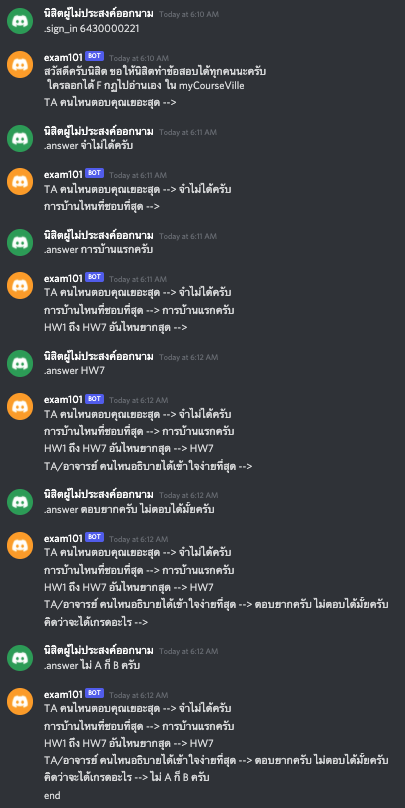